# Creating a kaggle Workflow

## surveying on the survived from tragedy of the titanic

In [1]:
### import the pandas library

import pandas as pd
import numpy as np

train= pd.read_csv("train.csv")
holdout= pd.read_csv("test.csv")
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_all(df):
    df= process_missing(df)
    df= process_age(df)
    df= process_fare(df)
    df= process_titles(df)
    df= process_cabin(df)
    cols= ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    for c in cols:
        df= create_dummies(df,c)  
    return df
train= process_all(train)
holdout= process_all(holdout)

### For to do a best pratice, we are going to use this cycle :

### - Data exploration
### - Features engineering
### - Features selection
### - Model selection/tuning

In [4]:
### Let's make our data exploration onto "SibSp","Parch" columns
cols= ["SibSp","Parch"]
print(train[cols].dtypes)

SibSp    int64
Parch    int64
dtype: object


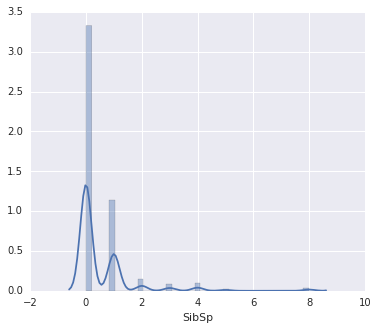

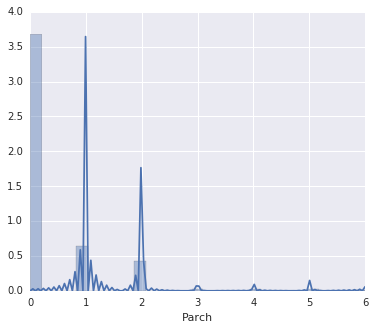

In [5]:
### Now let's visualize the distributions

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

for c in cols:
    fig,ax = plt.subplots(figsize=(6,5))
    ax= sns.distplot(train[c])
plt.show()

In [6]:
rate_s= pd.pivot_table(train,["SibSp","Parch"],"Survived")

In [7]:
rate_s

,Parch,SibSp
Survived,,
0,0.329690,0.553734
1,0.464912,0.473684


We can see that in the Parch column we have more survivors than deaths and in the SibSp column we have more deaths than survivors.

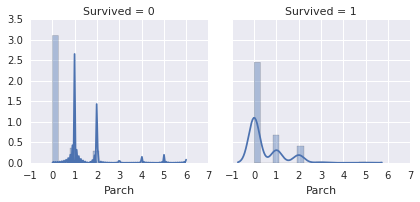

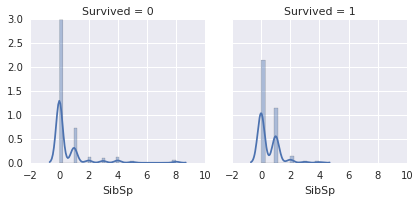

In [8]:
for c in ["Parch","SibSp"]:
    g= sns.FacetGrid(train,col="Survived")
    g.map(sns.distplot,c)
plt.show()

In [9]:
def isalone(val):
    if val>=1:
        return 0
    else:
        return 1
    
def new_feature(df):
    df['familysize'] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"]= df["familysize"].map(isalone)
    return df

train= new_feature(train)
holdout= new_feature(holdout)

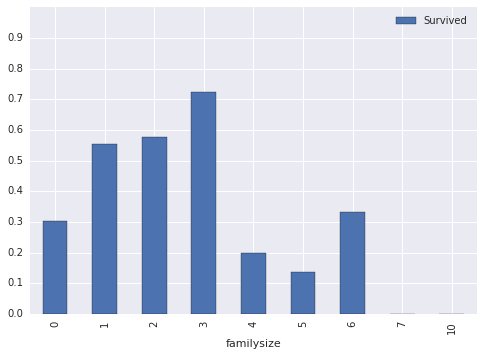

In [10]:
### Let's visualize the combined columns

explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)

pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [11]:
train.dtypes

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Fare_categories               category
Title                           object
Cabin_type                      object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

In [12]:
### Now we gonna search the best features who perfom better.

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df= df.select_dtypes(include="number")
    df= df.dropna(axis=1)
    all_X= df[df.drop(["PassengerId","Survived"],axis=1).columns]
    all_y= df["Survived"]
    rf= RandomForestClassifier(random_state=1)
    selector= RFECV(rf,cv= 10)
    selector.fit(all_X,all_y)
    optimized_columns= all_X.columns[selector.support_] 
    return optimized_columns

optimized_features= select_features(train)

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [17]:
### Now let's research the best model and parameters

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features):
    all_X= df[features]
    all_y= df["Survived"]
    models= [
        {"name": "LogisticRegression",
         "estimator": LogisticRegression(),
         "hyperparameters": {
             "solver": ["newton-cg", "lbfgs", "liblinear"]
         }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters": {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
                }
         }          
    ]
    for m in models:
        print(m["name"])
        gs= GridSearchCV(m["estimator"],param_grid= m["hyperparameters"],cv= 10)
        gs.fit(all_X,all_y)
        m["best_params"]= gs.best_params_
        m["best_score_"]= gs.best_score_
        m["best_estimator"]= gs.best_estimator_
        print("the best params: {}".format(m["best_params"]))
        print("the best score: {}".format(m["best_score_"]))
        print("the best estimator: {}".format(m["best_estimator"]))
    return models


In [19]:
best_model= select_model(train,optimized_features)
best_model

LogisticRegression
the best params: {'solver': 'newton-cg'}
the best score: 0.8181818181818182
the best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
KNeighborsClassifier
the best params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform', 'algorithm': 'kd_tree'}
the best score: 0.7800224466891134
the best estimator: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')
RandomForestClassifier
the best params: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 6, 'min_samples_leaf': 1, 'max_depth': 10, 'min_samples_split': 5}
the best score: 0.8428731762065096
the best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, crite

[{'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
            verbose=0, warm_start=False),
  'best_params': {'solver': 'newton-cg'},
  'best_score_': 0.8181818181818182,
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'name': 'LogisticRegression'},
 {'best_estimator': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=1,
             weights='uniform'),
  'best_params': {'algorithm': 'kd_tree',
   'n

In [23]:
def save_submission_file(trained_model,cols,filename):
    predictions= trained_model.predict(holdout[cols])
    df= {
        "PassengerId": holdout["PassengerId"],
        "Survived": predictions
    }
    submission_df= pd.DataFrame(df)
    submission_df.to_csv(filename,index= False)

In [24]:
model= best_model[2]["best_estimator"]
save_submission_file(model,optimized_features,"submission_3.csv")